In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_swiss_roll
from helper_plot import hdr_plot_style
import torch

hdr_plot_style()

In [17]:
def sample_batch(size, noise=0.5):
    x, _ = make_swiss_roll(size, noise=noise)
    return x[:, [0, 2]] / 10.0

data = sample_batch(10 ** 4).T

### Forward Process

In [18]:
def make_beta_schedule(schedule='linear', n_time_steps=1000, start=1e-5, end=1e-2):
    if schedule == 'linear':
        betas = torch.linspace(start, end, n_time_steps)
    elif schedule == 'quad':
        betas = torch.linspace(start ** .5, end ** .5, n_time_steps) ** 2
    elif schedule == 'sigmoid':
        betas = torch.linspace(-6, 6, n_time_steps)
        betas = torch.sigmoid(betas) * (end - start) + start
    return betas

In [19]:
# diffusion parameters
n_steps = 100
betas = make_beta_schedule(schedule='sigmoid', n_time_steps=n_steps, start=1e-5, end=1e-2)
alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, 0)
alphas_prod_p = torch.cat([torch.tensor([1]).float(), alphas_prod[:-1]], 0)
alphas_bar_sqrt = torch.sqrt(alphas_prod)

one_minus_alphas_bar_log = torch.log(1 - alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)

In [20]:
def extract(input, t, x):
    shape = x.shape
    out = torch.gather(input, 0, t)
    reshape = [t.shape[0]] + [1] * (len(shape) - 1)
    out = out.reshape(*reshape)
    return out

def q_sample(x_0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_0)
    alphas_t = extract(alphas_bar_sqrt, t, x_0)
    alphas_1_m_t = extract(one_minus_alphas_bar_sqrt, t, x_0)
    return alphas_t * x_0 + alphas_1_m_t * noise

def plot_diffusion():
    fig, axs = plt.subplots(1, 10, figsize=(28, 3))
    for t in range(10):
        q_i = q_sample(dataset, torch.tensor([t * 10]))
        axs[t].scatter(q_i[:, 0], q_i[:, 1], s=10)
        axs[t].set_axis_off()
        axs[t].set_title('$q(\mathbf{x}_{'+str(t*10)+'})')

In [21]:
# posterior q(x_{t-1} | x_t, x_0) parameters
posterior_mean_coef_1 = (betas * torch.sqrt(alphas_prod_p) / (1 - alphas_prod))
posterior_mean_coef_2 = ((1 - alphas_prod_p) * torch.sqrt(alphas) / (1 - alphas_prod))
posterior_variance = betas * (1 - alphas_prod_p) / (1 - alphas_prod)
posterior_log_variance_clipped = torch.log(torch.cat((posterior_variance[1].view(1,1), posterior_variance[1:].view(-1, 1)), 0)).view(-1)

In [22]:
def q_posterior_mean_variance(x_0, x_t, t):
    coef_1 = extract(posterior_mean_coef_1, t, x_0)
    coef_2 = extract(posterior_mean_coef_2, t, x_0)
    mean = coef_1 * x_0 + coef_2 * x_t
    var = extract(posterior_log_variance_clipped, t, x_0) # t = 0 일때 log var not defined
    return mean, var

### Reverse Process

In [23]:
import torch.nn.functional as F
from torch import nn, optim

class ConditionalLinear(nn.Module):
    def __init__(self, num_in, num_out, n_steps):
        super().__init__()
        self.num_out = num_out
        self.lin = nn.Linear(num_in, num_out)
        self.embed = nn.Embedding(n_steps, num_out)
        self.embed.weight.data.uniform_()

    def forward(self, x, t):
        out = self.lin(x)
        gamma = self.embed(t)
        out = gamma.view(-1, self.num_out) * out
        return out

class ConditionalModel(nn.Module):
    def __init__(self, n_steps):
        super().__init__()
        self.lin1 = ConditionalLinear(2, 128, n_steps)
        self.lin2 = ConditionalLinear(128, 128, n_steps)
        self.lin3 = nn.Linear(128, 4)
    
    def forward(self, x_t, t):
        x = F.softplus(self.lin1(x_t, t))
        x = F.softplus(self.lin2(x, t))
        return self.lin3(x)

In [24]:
def p_mean_variance(model, x, t):
    out = model(x, t)
    mean, log_var = torch.split(out, 2, dim=-1)
    return mean, log_var

def p_sample(model, x, t):
    mean, log_var = p_mean_variance(model, x, torch.tensor(t))
    noise = torch.randn_like(x)
    sample = mean + torch.exp(0.5 * log_var) * noise
    return (sample)

def p_sample_loop(model, shape):
    cur_x = torch.randn(shape)
    x_seq = [cur_x]
    for t in reversed(range(n_steps)):
        cur_x = p_sample(model, cur_x, t)
        x_seq.append(cur_x)
    return x_seq

In [25]:
def normal_kl(mean1, logvar1, mean2, logvar2):
    kl = 0.5 * (-1 + logvar2 - logvar1 + torch.exp(logvar1 - logvar2) + ((mean1 - mean2) ** 2) * torch.exp(-logvar2))
    return kl

def entropy(val):
    return (0.5 * (1 + np.log(2. * np.pi))) + 0.5 * np.log(val)

In [29]:
# Training loss from "Sohl-Dickstein, Deep unsupervised learning using nonequilibrium thermodynamics."
def compute_loss(true_mean, true_var, model_mean, model_var):
    # DKL(q(x_{t-1} | x_t, x_0) || p_\theta(x_{t-1} | x_t))
    KL = normal_kl(true_mean, true_var, model_mean, model_var).float()
    
    # H(X_0)
    H_start = entropy(betas[0].float()).float()

    # Constant 
    beta_full_trajectory = 1. - torch.exp(torch.sum(torch.log(alphas))).float()
    
    H_end = entropy(beta_full_trajectory.float()).float()
    
    H_prior = entropy(torch.tensor([1.])).float()
    negL_bound = KL * n_steps + H_start - H_end + H_prior

    negL_gauss = entropy(torch.tensor([1.])).float()
    negL_diff = negL_bound - negL_gauss
    
    L_diff_bits = negL_diff / np.log(2.)
    
    L_diff_bits_avg = L_diff_bits.mean()
    return L_diff_bits_avg

In [30]:
def loss_likelihood_bound(model, x_0):
    batch_size = x_0.shape[0]

    # Select a random step for each example
    t = torch.randint(0, n_steps, size=(batch_size // 2 + 1,))
    
    # Antithetic sampling
    t = torch.cat([t, n_steps - t -1], dim=0)[:batch_size].long()

    # Perform diffuion for step t
    x_t = q_sample(x_0, t)

    # Compute the true mean and variance
    true_mean, true_var = q_posterior_mean_variance(x_0, x_t, t)

    # Infer the mean and variance with our model
    model_mean, model_var = p_mean_variance(model, x_t, t)

    # Compute the loss
    loss = compute_loss(true_mean, true_var, model_mean, model_var)

    return loss
    

tensor(201.3060, grad_fn=<MeanBackward0>)
tensor(4.5938, grad_fn=<MeanBackward0>)
tensor(-0.4798, grad_fn=<MeanBackward0>)
tensor(4.5699, grad_fn=<MeanBackward0>)
tensor(-1.1138, grad_fn=<MeanBackward0>)
tensor(-0.5846, grad_fn=<MeanBackward0>)


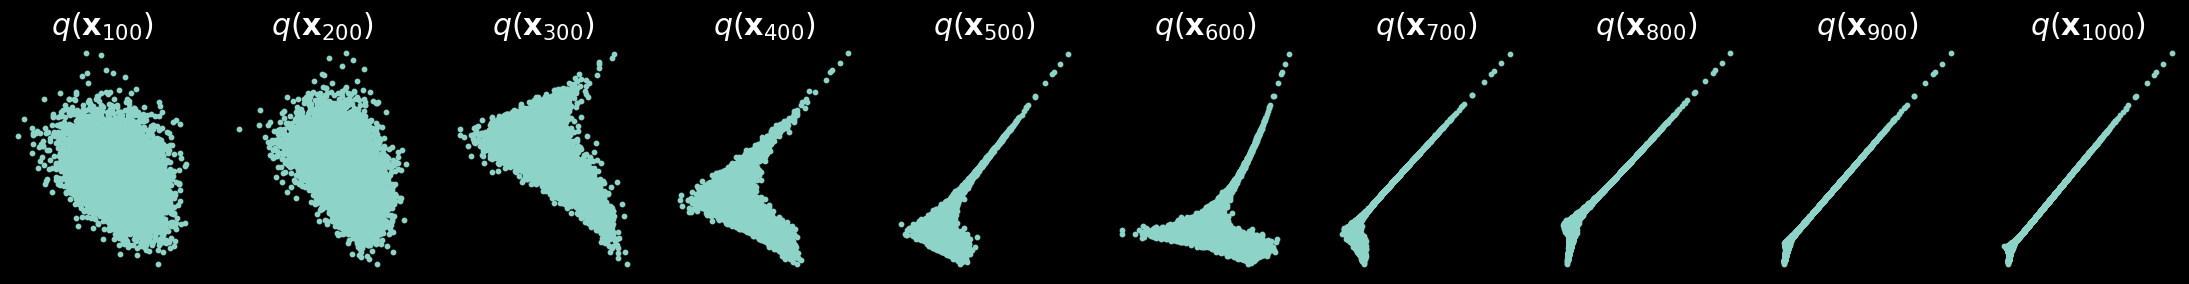

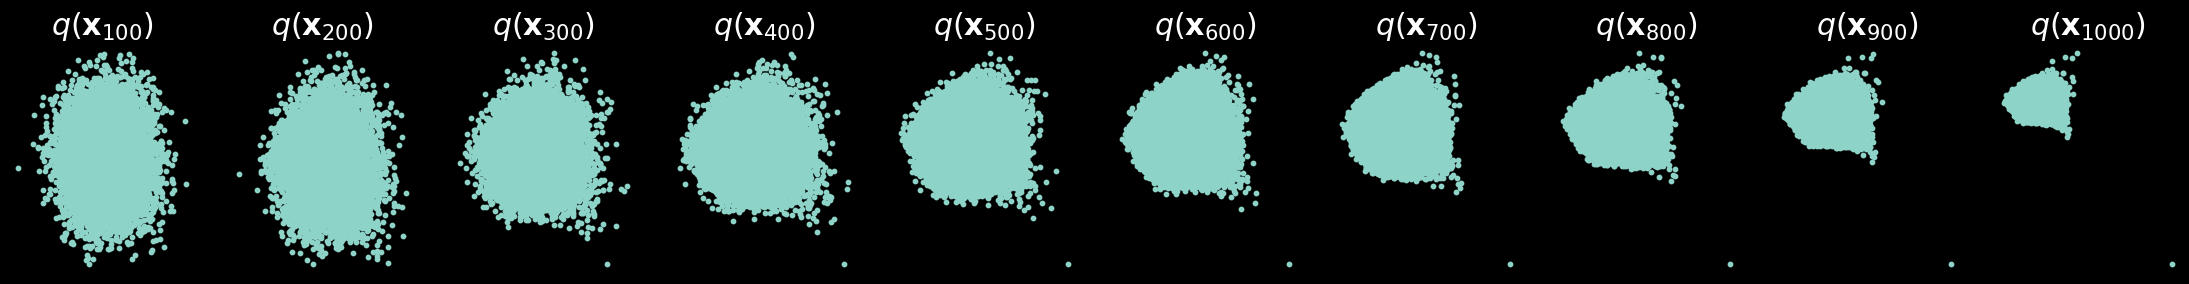

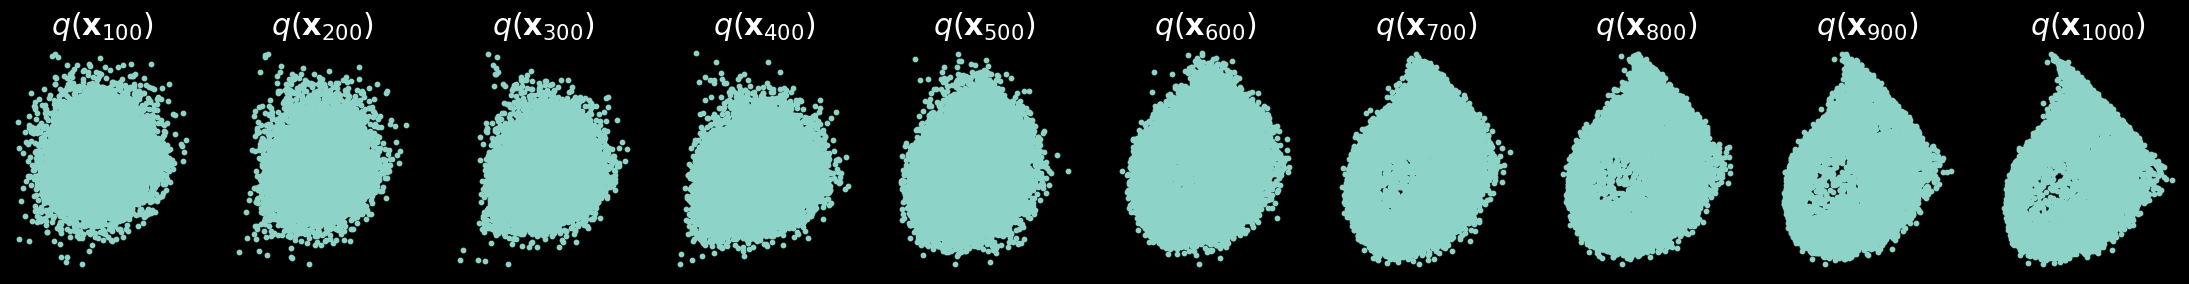

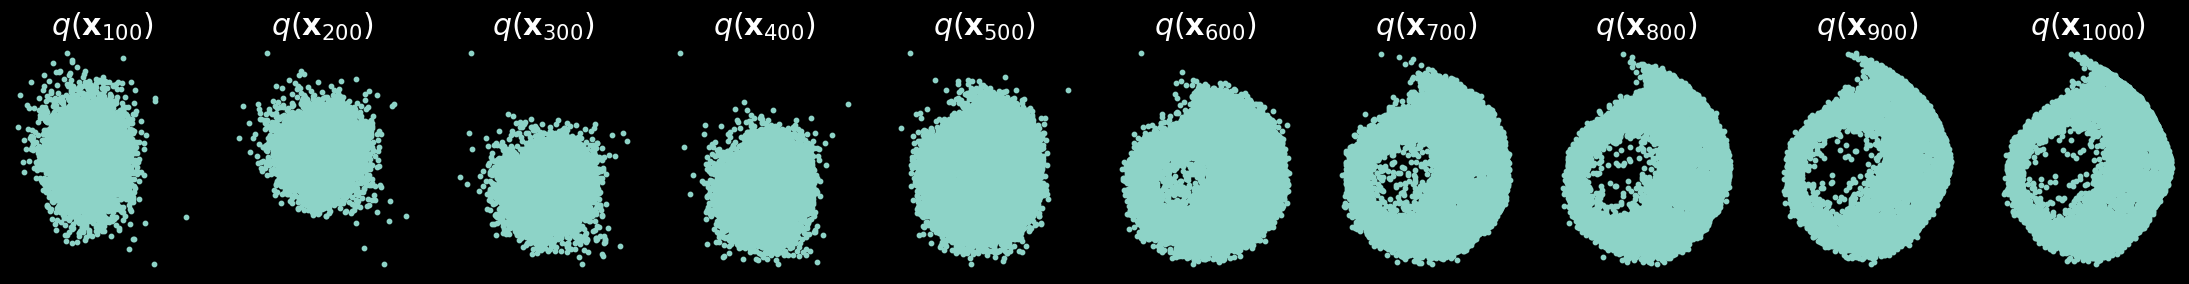

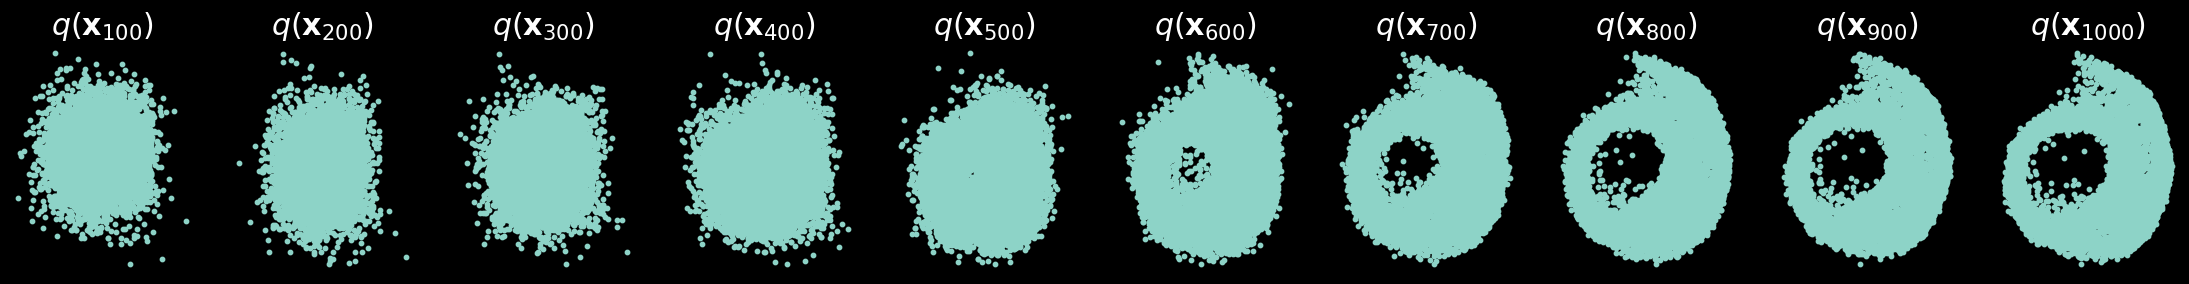

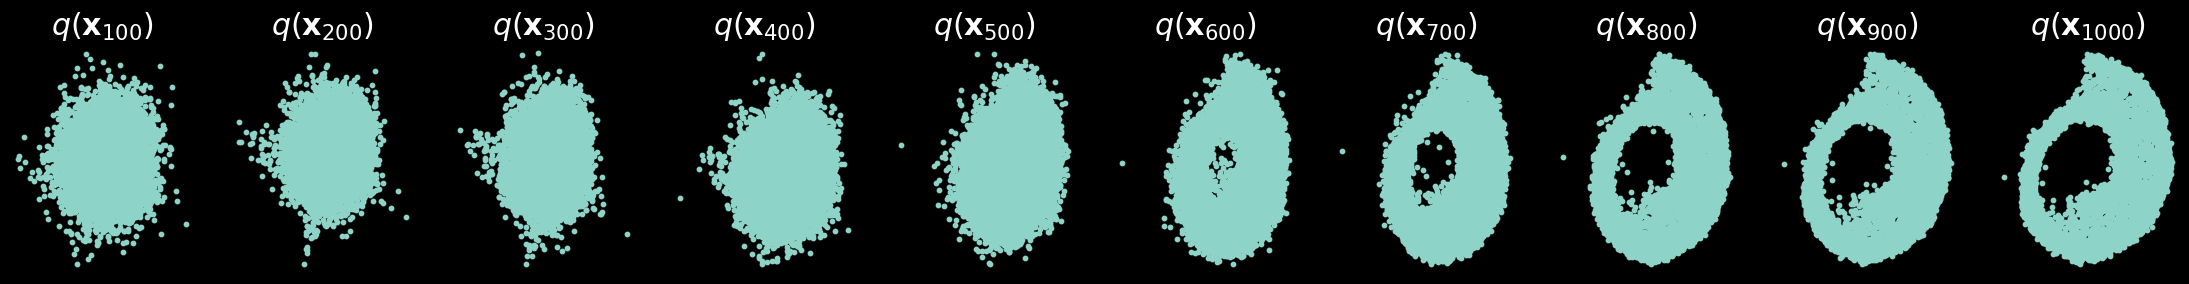

In [31]:
model = ConditionalModel(n_steps)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
dataset = torch.tensor(data.T).float()
batch_size = 128
for t in range(5001):
    # X is a torch Variable
    permutation = torch.randperm(dataset.size()[0])
    for i in range(0, dataset.size()[0], batch_size):
        # Retrieve current batch
        indices = permutation[i:i+batch_size]
        batch_x = dataset[indices]
        # Compute the loss.
        loss = loss_likelihood_bound(model, batch_x)
        # Before the backward pass, zero all of the network gradients
        optimizer.zero_grad()
        # Backward pass: compute gradient of the loss with respect to parameters
        loss.backward()
        # Perform gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        # Calling the step function to update the parameters
        optimizer.step()
    # Print loss
    if (t % 1000 == 0):
        print(loss)
        x_seq = p_sample_loop(model, dataset.shape)
        fig, axs = plt.subplots(1, 10, figsize=(28, 3))
        for i in range(1, 11):
            cur_x = x_seq[i * 10].detach()
            axs[i-1].scatter(cur_x[:, 0], cur_x[:, 1], s=10);
            axs[i-1].set_axis_off(); axs[i-1].set_title('$q(\mathbf{x}_{'+str(i*100)+'})$')